<a href="https://colab.research.google.com/github/jaredgs93/AutomatedGLMP/blob/main/src/notebooks/AutomatedGLMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated Granular Linguistic Model of Phenomena (GLMP) generation

This notebook automates the generation of a Granular Linguistic Model of a Phenomenon (GLMP) by processing multimodal data (audio, text, and video measures). The primary goal is to construct hierarchical models that enhance explainability by breaking down complex behaviors into interpretable components. Using structured inputs and aggregation techniques, the notebook facilitates the creation and visualization of GLMPs to better understand human-centric phenomena.

## Preliminary

The preliminary steps outline the foundation for automating the GLMP process. This includes defining the required resources, such as the OpenAI API and input files stored in a GitHub repository, as well as installing essential Python libraries like `openai` and `python-decouple`.

### Requirements

1. Files: The following files can be found at [https://github.com/jaredgs93/AutomatedGLMP.git](https://github.com/jaredgs93/AutomatedGLMP.git)

*   `prompt.txt`: It includes the detailed description of the task to be performed by the model. It indicates that it will receive two JSON files, which are as follows:
*   `measures.json`: Includes metrics obtained from a previously evaluated video.
*   `decision_making_base.txt`: It is the initial JSON structure of a phenomenon to be represented, i.e. the highest level of granularity.

2. An **OpenAI API Key** for accessing OpenAI services.

  **How to Get Your OpenAI API Key**

  * Go to the [OpenAI API Keys](https://platform.openai.com/account/api-keys) page.
  * Sign in or create an OpenAI account if you don’t already have one.
  * Click "Create new secret key" to generate a new API key.
  * Create a .env file which will be uploaded.
  * Copy the API key and paste it into the `OPENAI_API_KEY` field in your `.env` file.

### Installation of the necessary libraries


*  `openai`: Official OpenAI library that allows interaction with its AI models. In this case, it is used to access the `o1` model, allowing to send specific requests for GLMP (General Language Model Pre-training) text generation or custom tasks according to the model's capabilities.
*   `python-decouple`: A library that allows to manage sensitive settings, such as the OpenAI API key, from an .env file. This ensures that credentials are not included directly in the source code, improving security and facilitating the portability of the project.



In [ ]:
!pip install python-decouple
!pip install openai

## Implementation of GLMP Generation using Model o1

The following code is responsible for setting up the environment to ensure that the GLMP generation process runs smoothly. Here's a step-by-step explanation of what it does:


1. Prompt to Upload the `.env` File. The user is prompted to upload the `.env` file manually using `files.upload()`.
2. Check and Save the Uploaded File. The code checks if the `.env` file was successfully uploaded. If it is, it saves the file in the current working directory under the name `.env`. If not, an error is raised, ensuring the process halts until the file is correctly provided.
3. Load the `.env` File Using `python-decouple`. The `.env` file, which securely stores sensitive information like the OpenAI API key, is loaded using the `decouple` library. This ensures the credentials remain separate from the source code for security.
4. Retrieve and Validate the API Key. The OpenAI API key is retrieved from the `.env` file. The code verifies if the key was successfully loaded and outputs a confirmation message. If the key is missing, it raises an error, ensuring the user knows there is an issue with the file or its contents.



In [ ]:
from google.colab import files
from decouple import Config, RepositoryEnv
import os

# Upload the .env file manually
print("Please upload your .env file:")
uploaded = files.upload()

# Check if the .env file was uploaded
if '.env' in uploaded:
    print(".env successfully loaded")
    # Save the .env file
    env_path = '.env'
else:
    raise FileNotFoundError("The .env file did not load correctly. Please try again.")

# Retrieve the API Key
config = Config(RepositoryEnv(env_path))

# Validate the API Key
api_key = config('OPENAI_API_KEY', default=None)
if api_key:
    print("API Key loaded correctly.")
else:
    print("Error: Could not load API Key.")

Please upload your .env file:


Saving .env to .env
.env successfully loaded
API Key loaded correctly.


This part of the code clones the GitHub repository containing the required files for the GLMP process. The `base_path` is defined to specify the directory where these files are stored (`src/files`) within the cloned repository, ensuring seamless access to the necessary resources.

In [ ]:
# Cloning the repository from GitHub
!git clone https://github.com/jaredgs93/AutomatedGLMP.git

# Define the base project path of the files
base_path = "/content/AutomatedGLMP/src/files/skills"

Cloning into 'AutomatedGLMP'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 15 (delta 1), reused 14 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 4.76 KiB | 4.76 MiB/s, done.
Resolving deltas: 100% (1/1), done.


The OpenAI client is initialized with the API key retrieved from the `.env` file. The `json` library is imported to manage structured data, such as API responses.

In [ ]:
from openai import OpenAI
client = OpenAI(api_key = config('OPENAI_API_KEY'))
import json

The `prompt.txt` file is opened and read to retrieve the foundational description of GLMP generation. It includes the measures catalog, the structure for first-order perception mappings (1PMs), and guidelines for constructing hierarchical granularity and aggregation functions. This information is important for implementing the GLMP process accurately.

In [ ]:
with open(os.path.join(base_path, "prompt.txt"), "r",  encoding="utf8") as f:
    prompt = f.read()
print(prompt)

Multimodal video analysis allows text, audio and video to be extracted to detect certain human features. This is made possible by various machine learning techniques.

A set of measures has been defined for each modality, which is shown below. The measures are applicable to videos of up to 3 minutes where a person records him/herself looking at the camera and delivering a speech on a specific topic:

Audio measures:

    1) Noise: Audio detection of specific sequences or types of sequences (clearing). Proportion of noise in speech Scale [0,1].
    2) Fluency: Number of breaks and interruptions.
    3) Mood: Detection if reading (1), a normal tone (2) or a ‘passionate’ tone (3).
    4) Voice uniformity: In addition to considering the ‘mood’, it is corrected with respect to the mean fundamental frequency.
    5) Articulation: Syllables per second.
    6) Constancy: Absence of hesitation, pauses of longer duration, in the voice during speech. Ratio of pause time to total time. Scale [0-10

The `measures.json` file is loaded and parsed into a Python dictionary. This file contains a detailed set of metrics related to multimodal video analysis, such as audio, text, and video measures. These metrics include attributes like noise, fluency, mood, articulation, topic relevance, gaze, and emotions. The structured data will be used to populate the first-order perception mappings (1PMs) of the GLMP, forming the foundation for subsequent inferences and aggregations.

In [ ]:
with open(os.path.join(base_path, "measures.json"), "r") as f:
    metrics = json.load(f)
metrics

{'topic': 'machine learning',
 'duration (secs)': 77.85,
 'noise': 0.0,
 'fluency': 12,
 'mood': 'Passionately',
 'mood_weight': 10,
 'voice_uniformity': 5.9,
 'articulation': 5.95,
 'constancy': 10.0,
 'reaction_time': 0.9,
 'appropriateness_to_the_topic': 10.0,
 'congruence': 7.56,
 'concretion': 7.31,
 'adjectives': 10.0,
 'example': 5,
 'crutches': 0.77,
 'order': 3,
 'expression': 7.93,
 'organization': 6.92,
 'originality': 8.0,
 'no_redundancy': 6,
 'respect': 0,
 'verbal_tense': 2.0,
 'vagueness': 0.0,
 'quantity': 7.0,
 'relevance_topics': 95,
 'different_topics': 3,
 'vocabulary': 4.93,
 'ideas': 10,
 'postural_changes': 0.44,
 'gaze': 9.35,
 'blinking': 1.54,
 'smile': 0.0,
 'gesture': 5.0,
 'negative_emotion': 5.0,
 'positive_emotion': 5.0,
 'stress_emotion': 5.0,
 'mirada_furtiva': 0.65,
 'non_verbal_language': 8.5}

The `decision_making_base.txt` file is loaded and read as a string. This file contains the incomplete structure of a GLMP, where "decision_making" is the phenomenon being represented. The file is kept as a .txt to prevent errors that could occur when loading incomplete JSON files. This base can be adapted for other phenomena as needed and serves as the starting point for constructing a complete GLMP by populating its inputs, outputs, aggregation functions, and templates.

In [ ]:
with open(os.path.join(base_path, "decision_making_base.txt"), "r") as f:
    glmp_base = f.read()
print(glmp_base)

{
  "figure": "decision_making",
  "inputs": [
    
    
  ],
  "output": {
    "value": ,
    "linguistic_expressions": [
     
    ],
    "validity_degrees": [
     
    ]
  },
  "aggregation_function": {
    "type": "",
    "details": {
     
    },
    "universe": [
      
    ],
    "fuzzy_sets": [
    ]
  },
  "template": ""
}


The prompt is augmented with two JSON objects:

1. JSON 1: Contains the metrics parsed from the `measures.json` file.
2. JSON 2: Represents the incomplete GLMP structure loaded from the `decision_making_base.txt` file.
These are concatenated to provide the context required by the OpenAI API. Using the `o1-mini` model, the prompt is sent as part of a `chat.completions.create` request. The API will process the provided data, make inferences, and generate a response that completes the GLMP based on the given inputs and guidelines.

In [ ]:
prompt += "\n\n JSON 1: " + json.dumps(metrics) + "\n\n JSON 2: " + glmp_base


response = client.chat.completions.create(
    model="o1-mini",
    messages=[
        {
            "role": "user",
            "content": prompt
        }
    ]
)


Save the content from the response in a .txt file

In [ ]:
with open("response.txt", "w", encoding="utf8") as f:
    f.write(response.choices[0].message.content)

print(response.choices[0].message.content)

Certainly! Below is the completed JSON for the **Granular Linguistic Model of a Phenomenon (GLMP)** for the figure `"decision_making"`. This JSON incorporates multiple levels of granularity, starting from the first-order perception mappings (1PMs) derived directly from the measures catalogue provided in **JSON 1**. The model includes three levels of granularity, appropriate aggregation functions, fuzzy sets, and a natural language template for generating textual outputs.

```json
{
  "figure": "decision_making",
  "inputs": [
    {
      "figure": "Emotional_Intelligence",
      "inputs": [
        {
          "figure": "Mood_Weight",
          "inputs": [],
          "output": {
            "value": 10.0,
            "linguistic_expressions": ["high"],
            "validity_degrees": {
              "low": 0.0,
              "medium": 0.0,
              "high": 1.0
            }
          },
          "aggregation_function": {
            "type": "membership function",
            "de

The JSON object generated by the API is extracted by splitting the response text, isolating the raw JSON content for further use.

In [ ]:
json_str = response.choices[0].message.content.split("```json")[1].split("```")[0]
glmp_json = json.loads(json_str)

output_file = "generated_glmp.json"
with open(output_file, "w", encoding="utf8") as f:
    json.dump(glmp_json, f, ensure_ascii=False, indent=4)

print(f"JSON successfully saved in {output_file}")


JSON successfully saved in generated_glmp.json


## Visualization of structure

This section focuses on visualizing the hierarchical structure of the GLMP. A directed graph is generated, where nodes represent the components of the model, and edges point from children to their parent nodes. The graph is displayed with an intuitive layout, highlighting the relationships within the GLMP.

The following imports are used:

1. `networkx`: For creating, analyzing, and manipulating graphs and networks.
2. `matplotlib.pyplot`: For plotting and visualizing the graphs.
3. `graphviz_layout` (from `networkx.drawing.nx_pydot`): For generating hierarchical layouts using Graphviz, ideal for structured graph representations.

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout

The `build_glmp_upward_edges` function recursively traverses a GLMP structure to build a directed graph with upward-pointing edges (child to parent). Key steps include:

1. Node Addition: Nodes are added for elements with a `figure` key.
2. Edge Creation: For each node, an edge is added from the child to the parent, creating an upward flow in the graph.
3. Recursive Traversal: For each child in the `inputs` list, the function is called recursively, treating the current node as the parent.
4. Omission of Non-Figure Nodes: Numeric leaves (e.g., nodes with only a `value` key) are skipped to focus on figure-based nodes.
This function is essential for constructing the hierarchical structure of the GLMP as a directed graph.

In [ ]:
def build_glmp_upward_edges(glmp_node, graph, parent=None):
    """
    Recursively traverse the GLMP, adding figure-based nodes only,
    with edges from child -> parent (arrow pointing upward).
    Numeric leaves (e.g. { 'value': 0.9 }) are omitted.
    """
    figure_name = glmp_node.get("figure")
    if not figure_name:
        # Skip if there's no figure (probably just a numeric 'value' leaf)
        return

    # Add the node if it doesn't exist yet
    graph.add_node(figure_name)

    # If we have a parent, add an edge from child (this figure) -> parent
    # so the arrow will point upward to the higher-level node
    if parent is not None:
        graph.add_edge(figure_name, parent)

    # Recurse over each child in "inputs"
    for child in glmp_node.get("inputs", []):
        if isinstance(child, dict) and "figure" in child:
            # Child is another sub-node: pass current as 'parent'
            build_glmp_upward_edges(child, graph, parent=figure_name)
        # else if child is just {"value": ...}, omit it

The `plot_glmp_upward` function visualizes a GLMP as a directed graph with hierarchical structure. Key steps include:

1. Graph Creation: Initializes a directed graph (`DiGraph`) with edges pointing upward (child to parent).
2. Hierarchy Layout: Configures Graphviz to rank nodes from bottom to top (`rankdir: BT`) for a clear hierarchical representation.
3. Node and Edge Construction: Calls `build_glmp_upward_edges` to traverse the GLMP data and construct the graph.
4. Graphviz Layout: Uses `graphviz_layout` with the "dot" algorithm to position nodes in a structured hierarchy.
5. Visualization: Draws the graph using `matplotlib`, with customizable node size, color, and labels.

In [ ]:
def plot_glmp_upward(glmp_data, title="Decision Making GLMP"):
    """
    Build a hierarchy where the root is at the top,
    but edges point upward from children to parents.
    """
    # Create directed graph
    G = nx.DiGraph()
    # Tell Graphviz to rank from Bottom to Top
    G.graph["graph"] = {"rankdir": "BT"}

    # Build the upward‐pointing hierarchy
    build_glmp_upward_edges(glmp_data, G)

    # Use graphviz_layout with 'dot' to get a hierarchical layout
    pos = graphviz_layout(G, prog="dot")

    # Draw
    plt.figure(figsize=(8, 6))
    nx.draw(
        G, pos,
        with_labels=True,
        node_color="lightblue",
        node_size=2000,
        arrowsize=20,
        font_size=6
    )
    plt.title(title)
    plt.axis("off")
    plt.show()

The GLMP structure display is generated as a network.

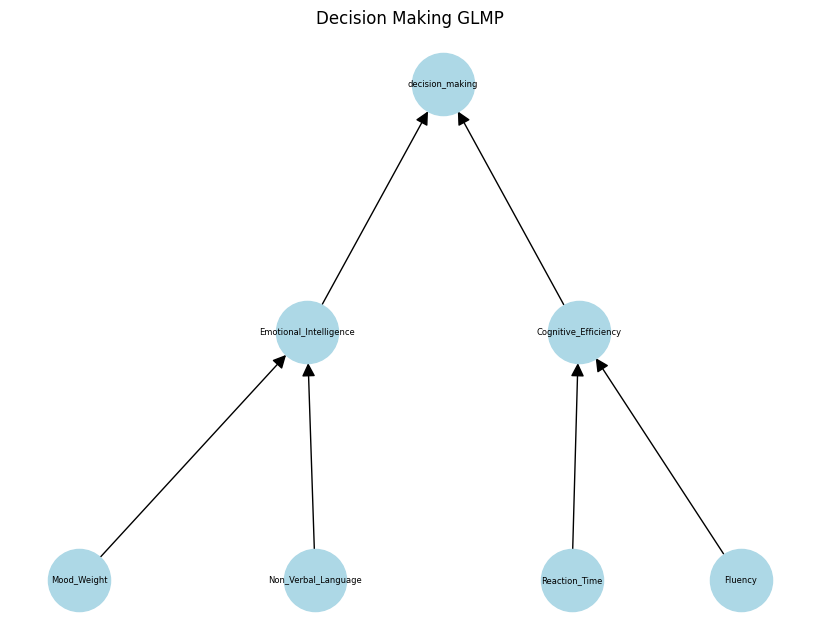

In [ ]:
if __name__ == "__main__":
    plot_glmp_upward(glmp_json)